# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.68KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

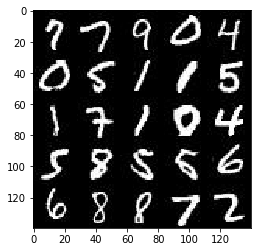

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

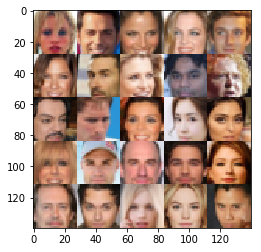

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
#         input 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x1 = tf.maximum(x1, alpha * x1)
#         14x14x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha * x3)
#         7x7x256 

        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 512, activation=None)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha * x1)
#         7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
#         14x14x128

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, alpha * x4)
#         28x28x64

#         28x28x out_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        logits = tf.layers.dropout(logits, rate=0.5)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
#               batch_images *=2 for matching generator
                batch_images *= 2                                                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6348... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.9325... Generator Loss: 4.1675
Epoch 1/2... Discriminator Loss: 2.6150... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 2.7844... Generator Loss: 4.8884
Epoch 1/2... Discriminator Loss: 2.1516... Generator Loss: 3.3611
Epoch 1/2... Discriminator Loss: 2.5491... Generator Loss: 3.3850
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 2.2001
Epoch 1/2... Discriminator Loss: 1.6112... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 2.3529... Generator Loss: 0.2659
Epoch 1/2... Discriminator Loss: 1.6288... Generator Loss: 0.8095


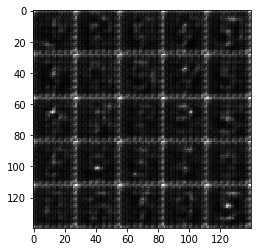

Epoch 1/2... Discriminator Loss: 1.7704... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.9518... Generator Loss: 0.4089
Epoch 1/2... Discriminator Loss: 1.9199... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 1.8844... Generator Loss: 0.3784
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.8614... Generator Loss: 1.8613
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 2.0525... Generator Loss: 2.2495
Epoch 1/2... Discriminator Loss: 1.8534... Generator Loss: 2.3374
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 1.7506


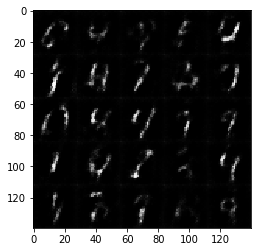

Epoch 1/2... Discriminator Loss: 1.5651... Generator Loss: 2.1526
Epoch 1/2... Discriminator Loss: 1.5555... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 1.3543
Epoch 1/2... Discriminator Loss: 1.8204... Generator Loss: 2.1980
Epoch 1/2... Discriminator Loss: 1.7093... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 1.6449
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.8144


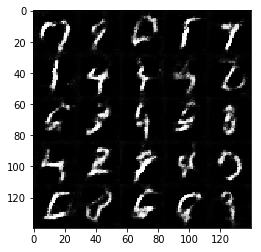

Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.8611... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 1.7524... Generator Loss: 1.9928
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.8642


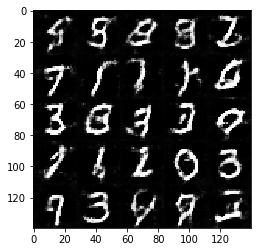

Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 1.9220
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 1.4762... Generator Loss: 1.9110
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 1.8391
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.5313
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 1.9869
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.7409


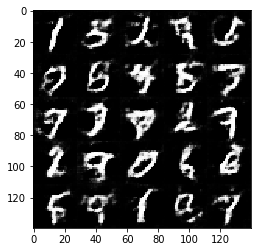

Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 1.6921
Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 1.4914
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.5256... Generator Loss: 2.0515
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 1.9289
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 1.5070


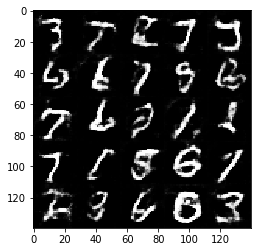

Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 1.0011
Epoch 1/2... Discriminator Loss: 1.7194... Generator Loss: 0.4838
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.5988


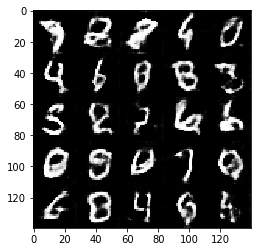

Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.6855... Generator Loss: 0.4790
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 1.3899
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 1.8941
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.8051... Generator Loss: 2.4366
Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 1.8205
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 1.4780
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.4130


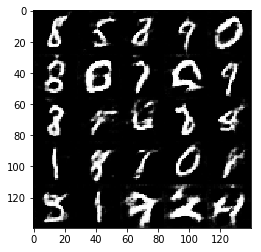

Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 1.4145
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 1.7786
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 1.5501
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 1.1735
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.5934


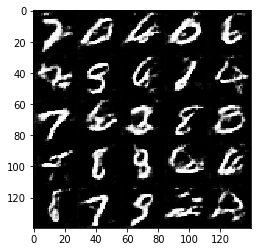

Epoch 1/2... Discriminator Loss: 1.6849... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 1.9522
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 1.7566
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 1.2576
Epoch 1/2... Discriminator Loss: 1.6423... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 1.7695


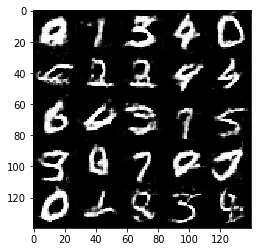

Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 1.4865
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 1.6203
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.3951
Epoch 1/2... Discriminator Loss: 1.5929... Generator Loss: 0.5116
Epoch 1/2... Discriminator Loss: 1.5753... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.7746... Generator Loss: 0.4025
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 2.3458


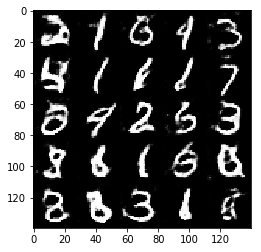

Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 1.7654
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 1.6225
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 1.4766
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 1.7265
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.7482


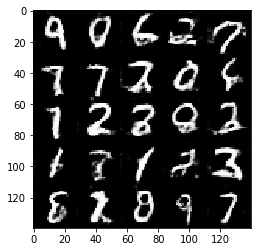

Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 1.3649
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 1.3832
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.6111... Generator Loss: 0.5713


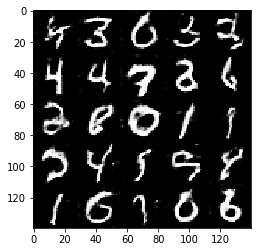

Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.2721
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7702


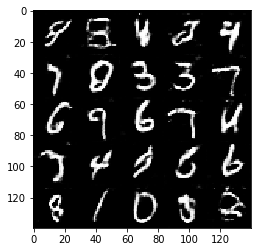

Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 1.4009
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 1.0345


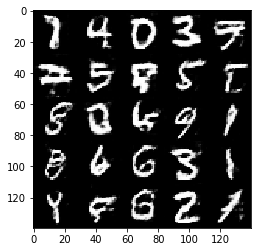

Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.8986
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.3749


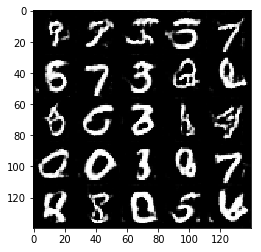

Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 1.2618
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.1786


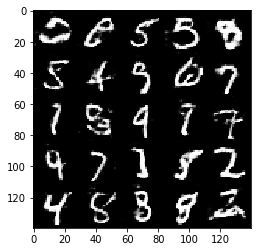

Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.4925
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 1.0237


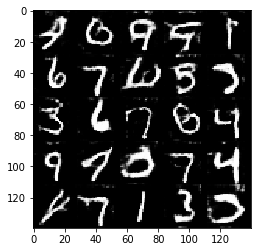

Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 1.5359
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 1.1379


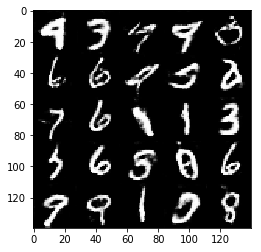

Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 1.5744... Generator Loss: 2.3158
Epoch 2/2... Discriminator Loss: 1.5176... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 1.8520
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.6477
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 1.6336


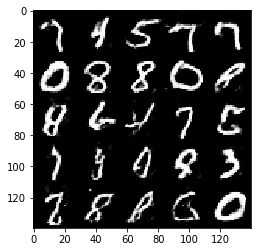

Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 1.8140
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.6728


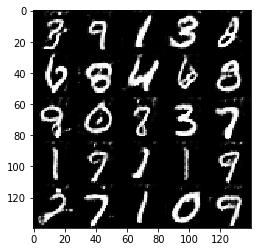

Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 1.4067
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 1.5861
Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 2.2390
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 1.1376
Epoch 2/2... Discriminator Loss: 1.5354... Generator Loss: 0.6051
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.2342
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 1.6424
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8577


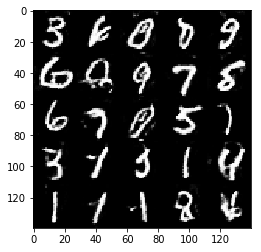

Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 1.6005
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 1.5864
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 2.1450
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 1.3617
Epoch 2/2... Discriminator Loss: 1.6153... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.9026


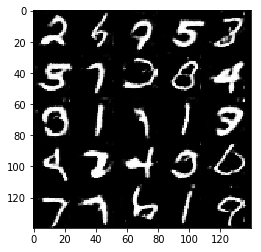

Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 1.2293
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 1.2487
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 1.0472


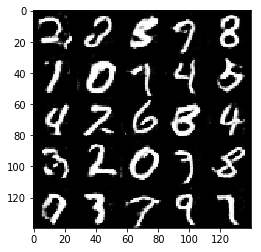

Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 1.1148
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 1.3616


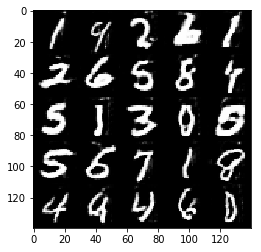

Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.6525... Generator Loss: 2.6117
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.4400... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 1.2137
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 0.6083


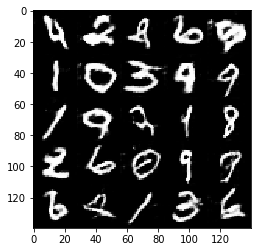

Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 1.5852
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.7398


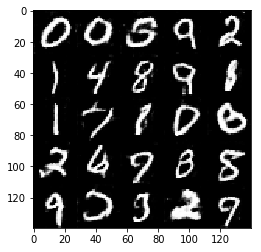

Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 2.2465
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 1.8793
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 2.1825
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.9429
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 1.4346


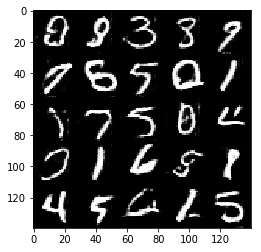

Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.4093
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 1.2119
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.5977
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 1.5108


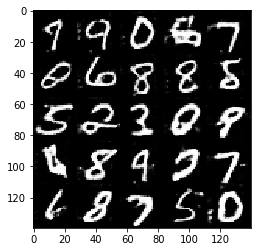

Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 1.7390
Epoch 2/2... Discriminator Loss: 1.6183... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.6800... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 1.7436
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 1.1121
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 1.8746
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 1.9443


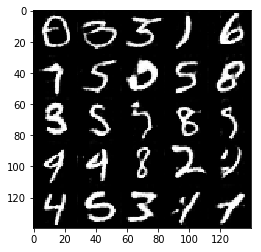

Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 1.5785
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 1.6043
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 1.1609
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 1.4482
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 1.5156


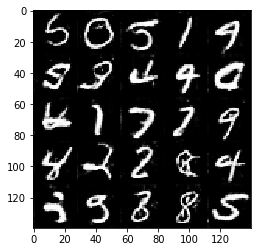

Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 2.2666... Generator Loss: 3.7860
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 1.7263
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 1.6719
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.2600
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 1.3461


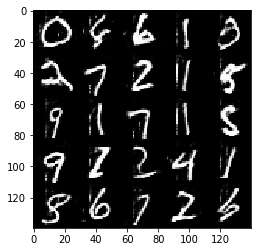

Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 2.2803
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 1.2059
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 2.3164
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 1.5873
Epoch 2/2... Discriminator Loss: 1.5297... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 2.2766


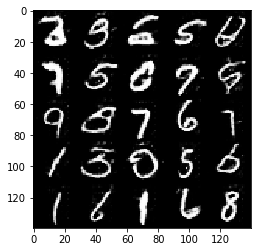

Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 1.1464
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 1.9042
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.7018


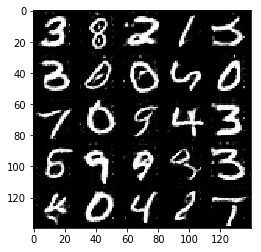

Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 1.2047
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.8022
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 2.1366
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 2.1176
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 2.2351


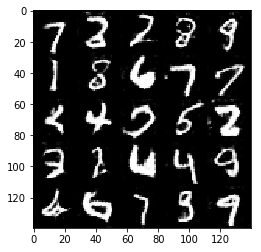

Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 1.6587... Generator Loss: 2.8248
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.5242
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 1.5725
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.4206
Epoch 2/2... Discriminator Loss: 2.0750... Generator Loss: 0.3679
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 1.6358
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 1.1847


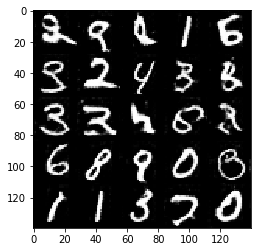

Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 2.0929
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 2.1072
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 1.2059
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.5671
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.3696


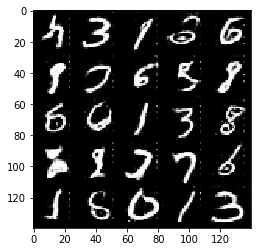

Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.4621
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 2.0873


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 5.9371
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 3.4902... Generator Loss: 0.0634
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 2.2896
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.9884... Generator Loss: 1.4837
Epoch 1/1... Discriminator Loss: 2.3036... Generator Loss: 0.1931


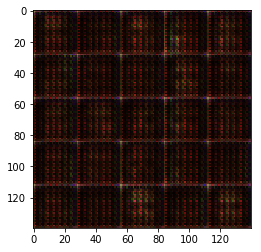

Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 1.8899... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 2.8148... Generator Loss: 0.0854
Epoch 1/1... Discriminator Loss: 2.0023... Generator Loss: 0.2848
Epoch 1/1... Discriminator Loss: 1.7460... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 2.0097... Generator Loss: 2.5399


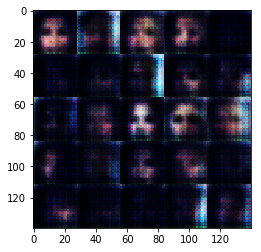

Epoch 1/1... Discriminator Loss: 2.4583... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 2.2392... Generator Loss: 1.7390
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 2.5994... Generator Loss: 0.1555
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.3583


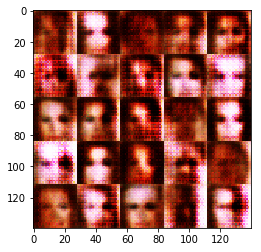

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.9407... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.9161... Generator Loss: 0.2656
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 2.0323... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 1.6234


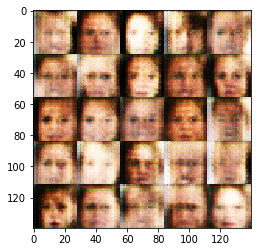

Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 0.2739
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.9314... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5953


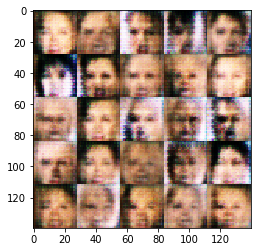

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.7881... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.9816... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.3953


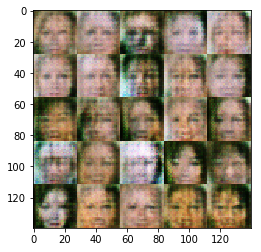

Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.6547


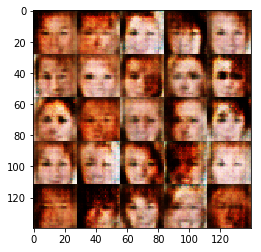

Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6046


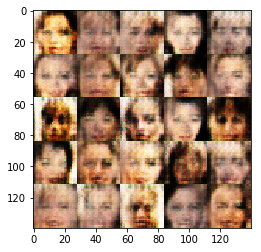

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 2.0351... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 2.3256... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 1.7416... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.3525


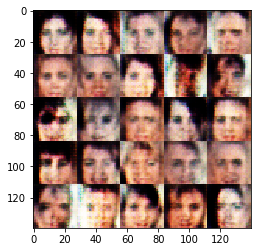

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.9244... Generator Loss: 0.3169
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.3859


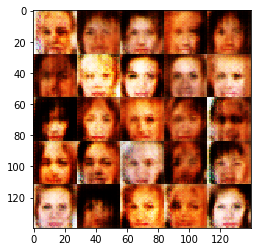

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8375


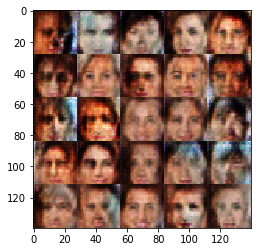

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.4865


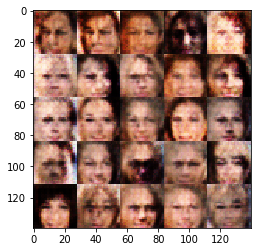

Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 0.2524
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.3549


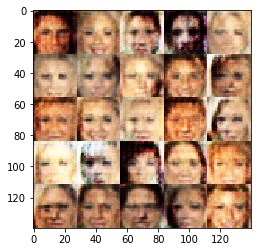

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6380


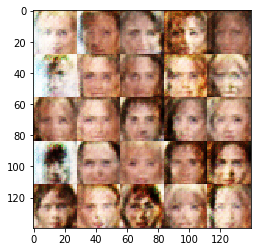

Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.6037


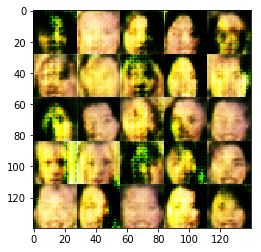

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 2.1910... Generator Loss: 0.1718
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 4.0422... Generator Loss: 2.3833


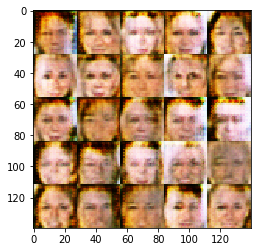

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.4242


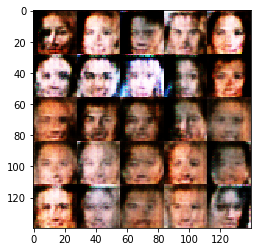

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 2.3404... Generator Loss: 0.2132
Epoch 1/1... Discriminator Loss: 1.8872... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 3.7752... Generator Loss: 0.0577


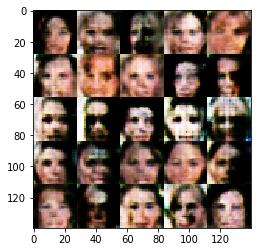

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.0130


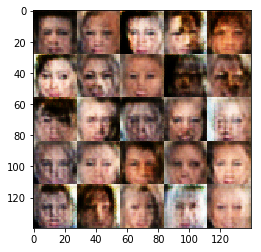

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.5548


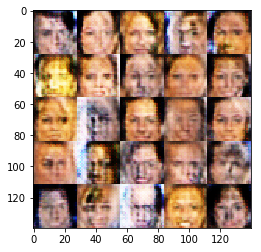

Epoch 1/1... Discriminator Loss: 1.7735... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.6831... Generator Loss: 0.3114


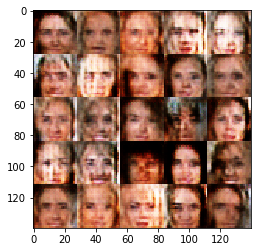

Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 0.7879


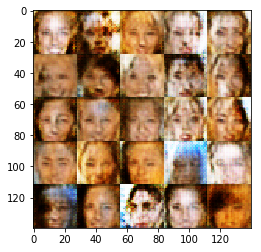

Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8855


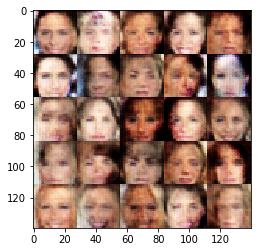

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7199


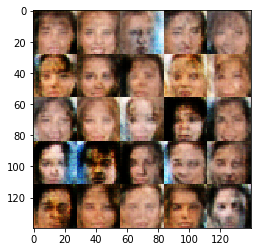

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 2.0497... Generator Loss: 1.9303
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.7538... Generator Loss: 0.3370


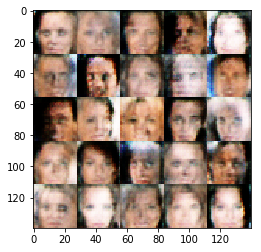

Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7480


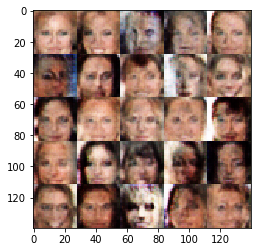

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.1437


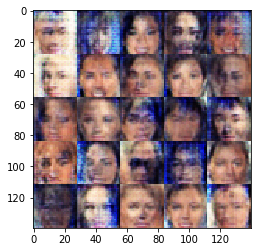

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.3614


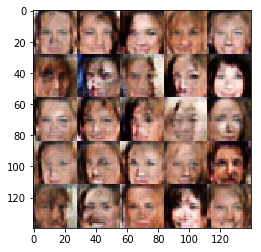

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.4857


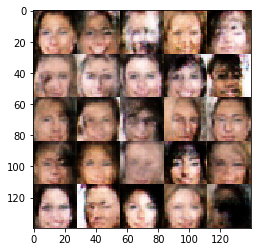

Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6688


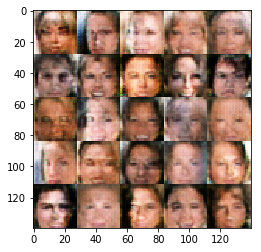

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.4903


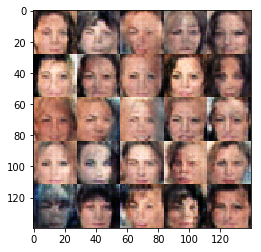

Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7986


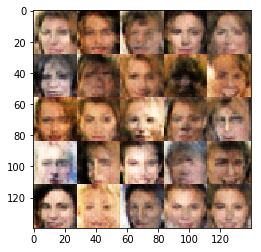

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6871


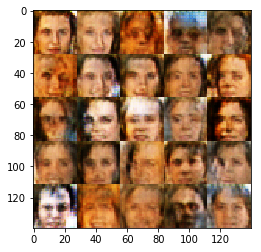

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5284


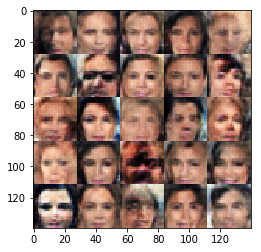

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5474


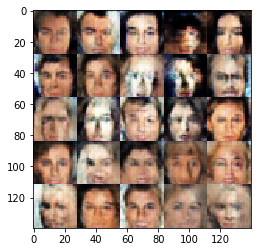

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.8100


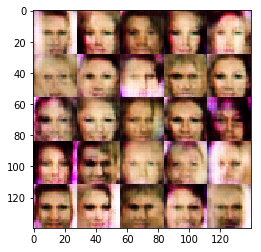

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8742


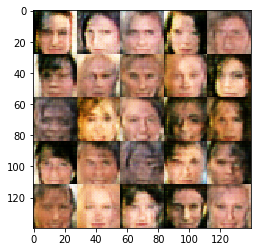

Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7019


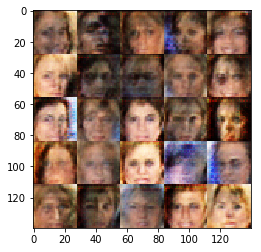

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6613


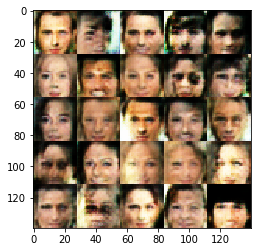

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6447


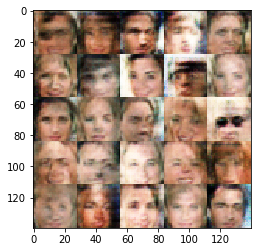

Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7618


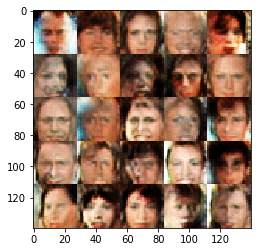

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5476


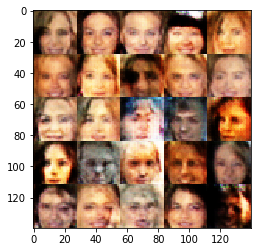

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.9158... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7476


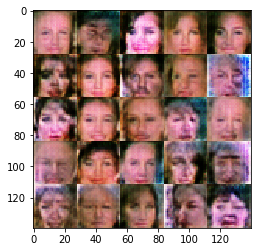

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7245


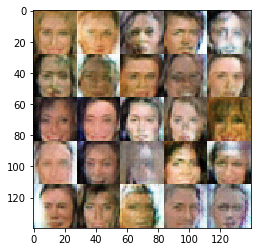

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4861


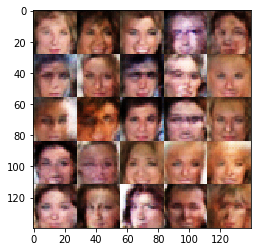

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 0.2876
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.5645


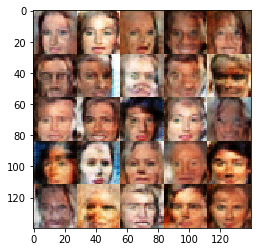

Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.9000... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.4451


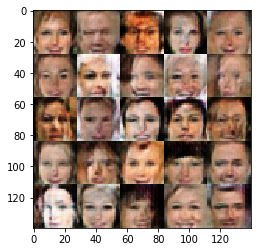

Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.5945


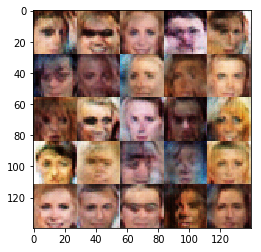

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6237


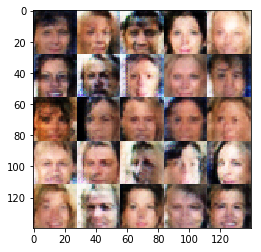

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8176


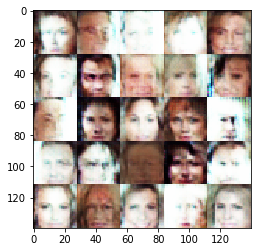

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5606


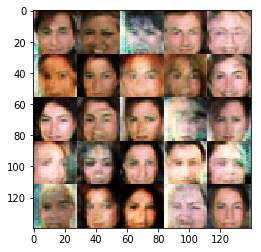

Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6576


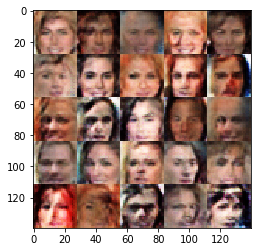

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6700


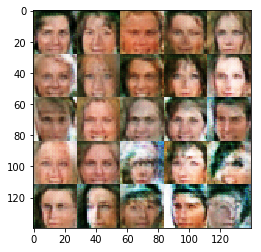

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6848


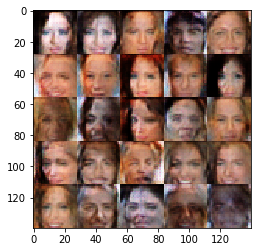

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 0.8525


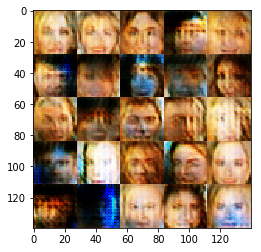

Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.3445


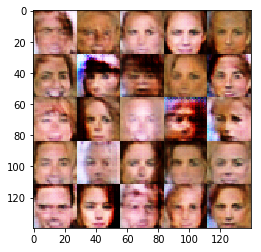

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7152


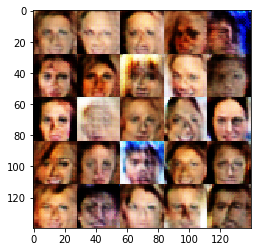

Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.4308
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.6209
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7787


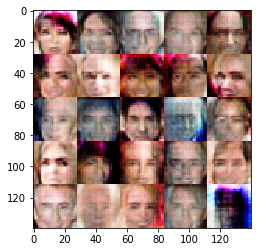

Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6939


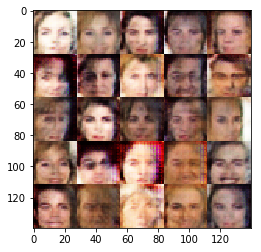

Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6188


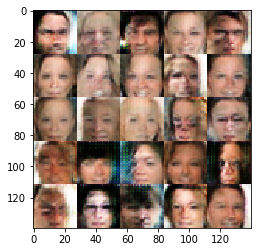

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.8380


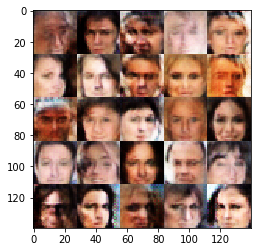

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5256


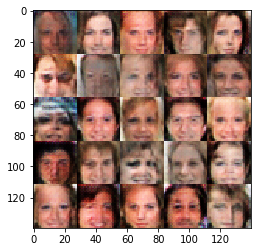

Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6494


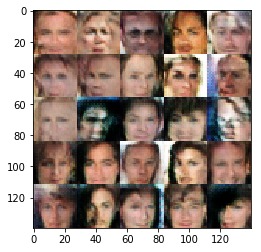

Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5826


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.